# Introducción

El filtrado colaborativo basado en artículos, también conocido como filtrado colaborativo artículo-artículo, es un tipo de algoritmo de sistema de recomendación que utiliza la similitud de artículos para recomendar productos.

En este tutorial, hablaremos sobre:
* ¿Qué es el filtrado colaborativo basado en artículos (artículo-artículo)?
* ¿Cómo crear una matriz usuario-producto?
* ¿Cómo identificar artículos similares?
* ¿Cómo clasificar los artículos para la recomendación?

**Hecho por prof. Carlos Ogando.**

*Este cuaderno está basado en los recursos de* [GrabnGoInfo](https://www.youtube.com/watch?v=cxcFi3RDrEw&list=PLVppujud2yJqshyM80nNDZgye-AFufyqF&index=1)

# Paso 0: Algoritmo de recomendación de filtrado colaborativo basado en productos

En primer lugar, comprendamos cómo funciona el filtrado colaborativo basado en productos.

El filtrado colaborativo basado en elementos genera recomendaciones basadas en interacciones previas entre usuarios y productos. El algoritmo asume que a los usuarios les gustan y les disgustan productos similares, por lo que otorgan calificaciones similares a productos similares.

El algoritmo de filtrado colaborativo basado en elementos suele constar de los siguientes pasos:

1. Calcular las puntuaciones de similitud de los elementos basándose en todas las calificaciones de los usuarios.
2. Identificar los n elementos más similares al elemento de interés.
3. Calcular la puntuación media ponderada de los elementos más similares según el usuario.
4. Clasificar los elementos según la puntuación y seleccionar los n elementos principales para recomendar.

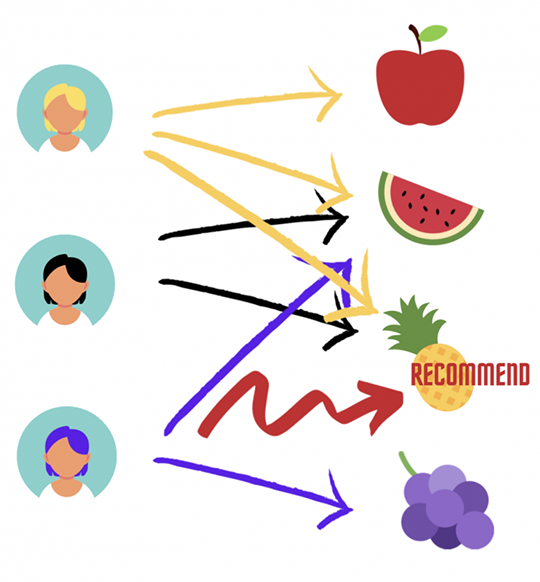

Este gráfico ilustra cómo funciona el filtrado colaborativo basado en elementos con un ejemplo simplificado.
* A la Sra. Rubia le gustan las manzanas, las sandías y las piñas. A la Sra. Negra le gustan las sandías y las piñas. A la Sra. Morada le gustan las sandías y las uvas.
* Dado que a las personas del mismo grupo les gustan las sandías y las piñas, se consideran artículos similares.
* Dado que a la Sra. Morada le gustan las sandías y aún no ha probado las piñas, el sistema de recomendaciones le recomienda las piñas.

# Paso 1: Importar librerías de Python

En el primer paso, importaremos las librerías de Python «pandas», «numpy» y «scipy.stats». Estas tres librerías se utilizan para el procesamiento y cálculo de datos.

También importamos «seaborn» para la visualización y «cosine_similarity» para calcular la puntuación de similitud.

In [1]:
# Procesamiento de datos
import pandas as pd
import numpy as np
import scipy.stats

# Visualización
import seaborn as sns

# Similaridad
from sklearn.metrics.pairwise import cosine_similarity

# Paso 2: Descargar y leer los datos

Este tutorial utiliza el conjunto de datos movielens. Este conjunto de datos contiene valoraciones reales de películas por parte de los usuarios.

En el paso 2, emplearemos el API de Google Drive para suplirnos de los conjuntos de datos.

*   La fuente que usaremos de kaggle será https://www.kaggle.com/datasets/ayushimishra2809/movielens-dataset?select=ratings.csv
*   La fuente original de los datos es http://movielens.org.

Pueden también usar sus propios datasets si así desean subiéndolos directamente al almacén de archivos temporales de Colab ubicado en el menú de la izquierda.

Hay varios conjuntos de datos en la carpeta 100k movielens. Para este tutorial, usaremos dos: ratings y películas.
Ahora, leamos los datos de ratings.

In [3]:
# Leer datos
ratings = pd.read_csv('Dataset películas/ratings.csv')

# Revisar la data
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


El conjunto de datos de calificaciones consta de cuatro columnas: ID de usuario, ID de película, calificación y marca de tiempo.

El conjunto de datos contiene más de 100 000 registros y no hay datos faltantes.

In [4]:
# Obtener la información del dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


Las 100.000 calificaciones provienen de 668 usuarios en 10,325 películas. La calificación tiene diez valores únicos, de 0,5 a 5.

In [5]:
# Número de usuarios
print('El dataset de ratings tiene', ratings['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El dataset de ratings tiene', ratings['movieId'].nunique(), 'películas únicas')

# Número de ratings
print('El dataset de ratings tiene', ratings['rating'].nunique(), 'ratings únicos')

# Listado de ratings únicos
print('Los ratings únicos son', sorted(ratings['rating'].unique()))

El dataset de ratings tiene 668 usuarios únicos
El dataset de ratings tiene 10325 películas únicas
El dataset de ratings tiene 10 ratings únicos
Los ratings únicos son [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


A continuación, leamos los datos de películas para obtener sus nombres.

El conjunto de datos de películas incluye el ID de la película, el título y los géneros.

In [6]:
# Leer datos
movies = pd.read_csv('Dataset películas/movies.csv')

# Revisión rápida
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Usando "movieID" como clave de coincidencia, agregamos la información de la película al conjunto de datos de clasificación y lo llamamos "df". Ahora tenemos el título y la clasificación de la película en el mismo conjunto de datos

In [7]:
# Unir datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Revisar resultado
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


# Paso 3: Análisis exploratorio de datos (EDA)

En el paso 3, necesitamos filtrar las películas y conservar solo aquellas con más de 100 valoraciones para el análisis. Esto facilita el cálculo en la memoria de Google Colab.

Para ello, primero agrupamos las películas por título, contamos el número de valoraciones y conservamos solo las películas con más de 100 valoraciones.

También se calculan las valoraciones promedio de las películas.

En la salida de `.info()`, podemos ver que quedan 134 películas.

In [8]:
# Agregar películas
agg_ratings = df.groupby('title').agg(
    mean_rating = ('rating', 'mean'),
    number_of_ratings = ('rating', 'count')
).reset_index()

# Filtrar solo el top 100 de ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              150 non-null    object 
 1   mean_rating        150 non-null    float64
 2   number_of_ratings  150 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ KB


Veamos cuáles son las películas más populares y sus valoraciones.

In [9]:
# Revisar películas famosas
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
7323,Pulp Fiction (1994),4.160000,325
3349,Forrest Gump (1994),4.138264,311
8136,"Shawshank Redemption, The (1994)",4.454545,308
4934,Jurassic Park (1993),3.659864,294
8228,"Silence of the Lambs, The (1991)",4.194828,290


A continuación, utilicemos un diagrama conjunto para comprobar la correlación entre la calificación promedio y el número de calificaciones.

Observamos una tendencia ascendente en el diagrama de dispersión, que muestra que las películas populares obtienen calificaciones más altas.

La distribución de la calificación promedio muestra que la mayoría de las películas del conjunto de datos tienen una calificación promedio de alrededor de 4.

La distribución del número de calificaciones muestra que la mayoría de las películas tienen menos de 150 calificaciones.

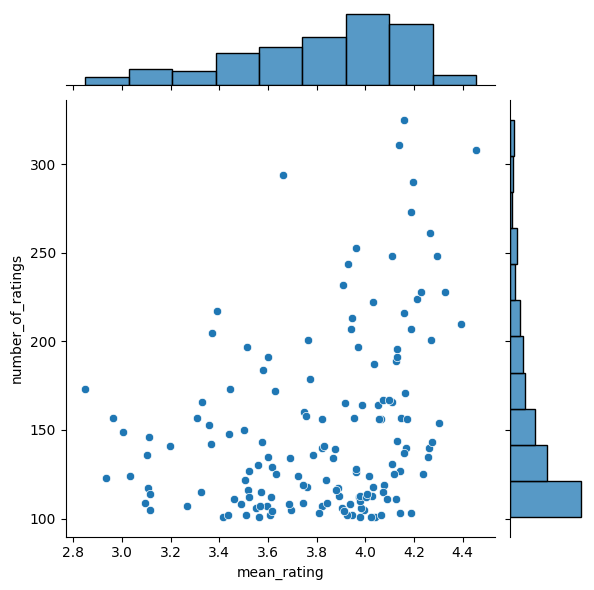

In [10]:
# Visualización
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

Para conservar solo las 150 películas con más de 100 calificaciones, necesitamos unir la película con el marco de datos de nivel de calificación del usuario.

`how='inner'` y `on='title'` garantizan que solo se incluyan las películas con más de 100 calificaciones.

In [11]:
# Unir datos
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     22556 non-null  int64  
 1   movieId    22556 non-null  int64  
 2   rating     22556 non-null  float64
 3   timestamp  22556 non-null  int64  
 4   title      22556 non-null  object 
 5   genres     22556 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.0+ MB


Después de filtrar las películas con más de 100 calificaciones, tenemos 653 usuarios que calificaron 150 películas.

In [12]:
# Número de usuarios
print('El dataset de ratings tiene', df_GT100['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El dataset de ratings tiene', df_GT100['movieId'].nunique(), 'películas únicas')

# Número de ratings
print('El dataset de ratings tiene', df_GT100['rating'].nunique(), 'ratings únicos')

# Listado de ratings únicos
print('Los ratings únicos son', sorted(df_GT100['rating'].unique()))

El dataset de ratings tiene 653 usuarios únicos
El dataset de ratings tiene 150 películas únicas
El dataset de ratings tiene 10 ratings únicos
Los ratings únicos son [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


# Paso 4: Crear una matriz de Película-Usuario

En el paso 4, transformaremos el conjunto de datos a una matriz. Las filas de la matriz representan las películas y las columnas los usuarios. El valor de la matriz es la calificación de la película por parte de los usuarios, si la hay. De lo contrario, se mostrará "NaN".

In [13]:
# Crear matriz usuario-item
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.5,NaN
Aladdin (1992),NaN,NaN,3.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Alien (1979),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,2.0,NaN,4.0,NaN,4.0
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5


# Paso 5: Normalización de datos

Dado que algunas personas tienden a dar una calificación más alta que otras, normalizamos la calificación extrayendo la calificación promedio de cada usuario.

Tras la normalización, las películas con una calificación menor a la calificación promedio del usuario obtienen un valor negativo, y las películas con una calificación mayor a la calificación promedio del usuario, un valor positivo.

In [14]:
# Normalización de la matriz usuario-item
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.039683,NaN,NaN,NaN,NaN,NaN,-0.960317
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-1.849711,NaN,-1.849711,NaN,-0.849711,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.150289,NaN,0.650289,NaN
Aladdin (1992),NaN,NaN,-0.602094,NaN,-0.102094,NaN,NaN,NaN,NaN,NaN,...,-0.602094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.602094
Alien (1979),NaN,NaN,NaN,NaN,NaN,NaN,0.935897,NaN,NaN,NaN,...,NaN,NaN,NaN,0.935897,NaN,-2.064103,NaN,-0.064103,NaN,-0.064103
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,0.853503,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.646497


# Paso 6: Calcular score de similaridad

Existen diferentes maneras de medir similitudes. La correlación de Pearson y la similitud de coseno son dos métodos ampliamente utilizados.

En este tutorial, calcularemos la matriz de similitud de usuarios mediante la correlación de Pearson.

In [15]:
# Matriz de similitud de productos utilizando correlación de Pearson
item_similarity = matrix_norm.T.corr()
item_similarity.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000)
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),1.000000,0.009197,0.094955,0.161791,0.111129,0.255150,0.326736,-0.116787,0.339217,0.375652,...,0.133435,0.175824,0.364667,0.355418,0.175233,0.473549,0.389881,0.069144,0.360623,0.081901
Ace Ventura: Pet Detective (1994),0.009197,1.000000,0.045501,0.220471,0.017538,0.184113,0.264089,0.092017,0.536903,-0.231039,...,0.414541,-0.065448,0.180731,0.124333,0.122249,0.350943,0.418543,0.289430,-0.047664,0.109188
Aladdin (1992),0.094955,0.045501,1.000000,0.131826,0.256574,0.188945,0.074428,0.293284,0.363807,0.027862,...,0.419170,0.023321,0.355073,0.285138,0.223299,0.285658,0.520339,0.330666,0.238034,0.335238
Alien (1979),0.161791,0.220471,0.131826,1.000000,0.556528,0.008468,0.272213,0.115971,0.326924,0.189564,...,0.493435,0.160803,0.198784,0.255713,0.280980,0.087540,0.430520,0.260268,0.299903,0.144456
Aliens (1986),0.111129,0.017538,0.256574,0.556528,1.000000,0.179657,0.195056,0.200158,0.339430,0.305410,...,0.348262,0.116643,0.225911,0.297400,0.218770,0.278225,0.413528,0.011283,0.238814,0.026598


Quienes estén interesados ​​en usar la similitud de coseno pueden consultar este código. Dado que `cosine_similarity` no acepta valores faltantes, debemos imputarlos con ceros antes del cálculo.

In [16]:
# Matriz de similitud de productos utilizando similaridad del coseno
item_similarity_cosine = pd.DataFrame(cosine_similarity(matrix_norm.fillna(0)),
                                      columns=item_similarity.columns, index=item_similarity.index)
item_similarity_cosine.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000)
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),1.000000,0.002398,0.030362,0.102831,0.068432,0.087204,0.100289,-0.029430,0.100589,0.184160,...,0.046372,0.070273,0.089081,0.142024,0.040875,0.078542,0.144135,0.030453,0.186945,0.026622
Ace Ventura: Pet Detective (1994),0.002398,1.000000,0.028470,0.065664,0.007766,0.036578,0.109186,0.024869,0.215627,-0.060172,...,0.165866,-0.032063,0.070456,0.055699,0.074808,0.149311,0.151619,0.108168,-0.010717,0.033203
Aladdin (1992),0.030362,0.028470,1.000000,0.051684,0.097400,0.030984,0.029856,0.090170,0.116300,0.007502,...,0.157308,0.010936,0.164669,0.146599,0.111028,0.149122,0.211902,0.135560,0.088557,0.096312
Alien (1979),0.102831,0.065664,0.051684,1.000000,0.376007,0.007532,0.123323,0.042557,0.133125,0.092797,...,0.214591,0.076489,0.071533,0.117668,0.081496,0.027983,0.195371,0.107275,0.123400,0.062152
Aliens (1986),0.068432,0.007766,0.097400,0.376007,1.000000,0.046216,0.084222,0.073928,0.105943,0.141798,...,0.121561,0.055561,0.070108,0.118617,0.060372,0.044269,0.170496,0.003122,0.082700,0.012711


En la matriz de similitud de películas, los valores van de -1 a 1, donde -1 significa películas opuestas y 1 significa películas similares.

# Paso 7: Predecir la calificación del usuario para una película

En el paso 7, predeciremos la calificación de un usuario para una película. Tomemos como ejemplo al usuario 1 y la película "American Pie".

La predicción sigue el siguiente proceso:
1. Crear una lista de las películas que el usuario 1 ha visto y calificado.
2. Clasificar las similitudes entre las películas calificadas por el usuario 1 y "American Pie".
3. Seleccionar las n películas con las puntuaciones de similitud más altas.
4. Calcular la calificación predicha utilizando el promedio ponderado de las puntuaciones de similitud y las calificaciones del usuario 1.

Ahora implementemos el proceso con Python.

Primero, eliminamos todas las películas que no tenían calificación para el usuario 1 y las ordenamos según la calificación.

In [17]:
# Escoger ID de usuario
picked_userid = 1

# Escoger la película
picked_movie = 'American Pie (1999)'

# Buscar las películas que la persona ha visto
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={1:'rating'})

picked_userid_watched.head()

,title,rating
0,Full Metal Jacket (1987),0.873874
1,Fight Club (1999),0.811594
2,Clear and Present Danger (1994),0.809701
3,"Silence of the Lambs, The (1991)",0.805172
4,Casablanca (1942),0.764000


Podemos ver que la película favorita del usuario 1 es "Full Metal Jacket", seguida de "Fight Club" y "Clear and Present Danger".

A continuación, obtenemos el puntaje de similitud de la película American Pie con la película que ha visto el usuario 1 y elegimos las 5 películas principales con el puntaje de similitud más alto.

In [19]:
# Puntuación de similitud de la película American Pie con todas las demás películas
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={'American Pie (1999)':'similarity_score'})

# Clasifica las similitudes entre las películas calificadas por el usuario 1 y American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                            right=picked_movie_similarity_score,
                                            on='title',
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

# Echa un vistazo a las películas que el Usuario 1 vio con mayor similitud
picked_userid_watched_similarity

,title,rating,similarity_score
46,Ghostbusters (a.k.a. Ghost Busters) (1984),-0.374101,0.570166
23,Independence Day (a.k.a. ID4) (1996),0.129268,0.510070
29,Mission: Impossible (1996),0.057803,0.503897
64,There's Something About Mary (1998),-2.111607,0.413760
20,"Matrix, The (1999)",0.235632,0.411696


Después, calcula el promedio ponderado de las calificaciones y las similitudes, de modo que las películas con mayor similitud tengan mayor peso. Este promedio ponderado es la calificación prevista para American Pie por el usuario 1.

In [20]:
# Calcule la calificación prevista utilizando el promedio ponderado de los puntajes de similitud y las calificaciones del usuario 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'The rating predicho para {picked_movie} por el usuario {picked_userid} es {predicted_rating}' )

The rating predicho para American Pie (1999) por el usuario 1 es -0.371402


# Paso 8: Recomendación de películas

En el paso 8, crearemos un sistema de recomendaciones de películas elemento por elemento siguiendo cuatro pasos:
1. Crear una lista de películas que el usuario objetivo no haya visto antes.
2. Recorrer las películas no vistas y crear puntuaciones previstas para cada una.
3. Clasificar la puntuación prevista de las películas no vistas de mayor a menor.
4. Seleccionar las k películas principales como recomendaciones para el usuario objetivo.

La función de Python a continuación implementó los cuatro pasos. Con los datos `picked_userid`, `number_of_similar_items` y `number_of_recommendations`, podemos obtener las películas favoritas del usuario y sus puntuaciones correspondientes. Tenga en cuenta que las puntuaciones se normalizan extrayendo la puntuación media de la película, por lo que debemos añadir el valor medio a las puntuaciones previstas si queremos que estas se encuentren en la misma escala que las puntuaciones originales.

In [21]:
# Función de recomendación basada en productos
def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Películas que el usuario objetivo no ha visto
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[1]==True]['title'].values.tolist()

  # Películas que el usuario objetivo ha visto
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={1:'rating'})

  # Diccionario para guardar la película no vista y el par de calificación prevista
  rating_prediction ={}

  # Iterar por cada película no vista
  for picked_movie in picked_userid_unwatched:
    # Calcular el score de similaridad de la película con las demás películas
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rankear las similitudes entre la película vista por el usuario seleccionado y la película no vista por el usuario seleccionado.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                right=picked_movie_similarity_score,
                                                on='title',
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calcule la calificación prevista utilizando el promedio ponderado de las puntuaciones de similitud y las calificaciones del usuario 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Guardar el rating predicho en el diccionario
    rating_prediction[picked_movie] = predicted_rating
    # Return el top películas recomendadas
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Obtener recomendaciones
recommended_movie = item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie

[('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
  np.float64(0.478495)),
 ('Memento (2000)', np.float64(0.42434)),
 ('Austin Powers: International Man of Mystery (1997)', np.float64(0.381164))]

# Paso 9: Unir todo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB
El dataset de valoraciones tiene 668 usuarios únicos
El dataset de valoraciones tiene 10325 películas únicas
El dataset de valoraciones tiene 10 valoraciones únicas
Las valoraciones únicas son [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]
<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              150 non-

[('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
  np.float64(0.478495)),
 ('Memento (2000)', np.float64(0.42434)),
 ('Austin Powers: International Man of Mystery (1997)', np.float64(0.381164))]

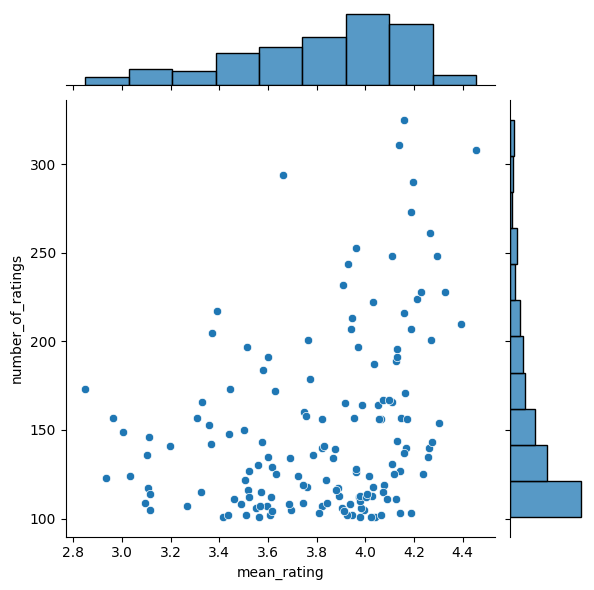

In [23]:
###### Paso 1: Importar Librerías de Python

# Procesamiento de datos
import pandas as pd
import numpy as np
import scipy.stats

# Visualización
import seaborn as sns

# Similitud
from sklearn.metrics.pairwise import cosine_similarity


###### Paso 2: Descargar y Leer los Datos

# Leer datos
ratings = pd.read_csv('Dataset películas/ratings.csv')

# Revisar los datos
ratings.head()

# Obtener información del dataset
ratings.info()

# Número de usuarios
print('El dataset de valoraciones tiene', ratings['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El dataset de valoraciones tiene', ratings['movieId'].nunique(), 'películas únicas')

# Número de valoraciones
print('El dataset de valoraciones tiene', ratings['rating'].nunique(), 'valoraciones únicas')

# Lista de valoraciones únicas
print('Las valoraciones únicas son', sorted(ratings['rating'].unique()))

# Leer información de películas
movies = pd.read_csv('Dataset películas/movies.csv')

# Ver una muestra de los datos
movies.head()

# Unir datasets de valoraciones y películas
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Ver una muestra de los datos
df.head()


###### Paso 3: Análisis Exploratorio de Datos (EDA)

# Agrupar por película
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                       number_of_ratings = ('rating', 'count')).reset_index()

# Conservar películas con más de 100 valoraciones
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

# Ver películas populares
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

# Visualización
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

# Unir datos
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

# Número de usuarios
print('El dataset filtrado tiene', df_GT100['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El dataset filtrado tiene', df_GT100['movieId'].nunique(), 'películas únicas')

# Número de valoraciones
print('El dataset filtrado tiene', df_GT100['rating'].nunique(), 'valoraciones únicas')

# Lista de valoraciones únicas
print('Las valoraciones únicas son', sorted(df_GT100['rating'].unique()))


###### Paso 4: Crear la Matriz Usuario-Película

# Crear matriz usuario-item
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()


###### Paso 5: Normalización de Datos

# Normalizar la matriz usuario-item
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()


###### Paso 6: Calcular la Matriz de Similitud

# Matriz de similitud entre ítems usando correlación de Pearson
item_similarity = matrix_norm.T.corr()
item_similarity.head()

# Matriz de similitud entre ítems usando similitud coseno
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine


###### Paso 7: Predecir la Valoración de un Usuario para una Película

# Seleccionar un usuario
picked_userid = 1

# Seleccionar una película
picked_movie = 'American Pie (1999)'

# Películas que el usuario ya ha visto
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={1:'rating'})

picked_userid_watched.head()

# Puntuación de similitud de 'American Pie' con el resto de películas
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={'American Pie (1999)':'similarity_score'})

# Ordenar las similitudes entre las películas vistas por el usuario 1 y 'American Pie'
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                            right=picked_movie_similarity_score,
                                            on='title',
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

# Ver las películas más similares que ha visto el usuario
picked_userid_watched_similarity

# Calcular la valoración predicha usando el promedio ponderado de similitudes y valoraciones
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'La valoración predicha para {picked_movie} por el usuario {picked_userid} es {predicted_rating}')


###### Paso 8: Recomendación de Películas

# Función de recomendación basada en ítems
def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Películas que el usuario no ha visto
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[1]==True]['title'].values.tolist()

  # Películas que el usuario sí ha visto
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={1:'rating'})

  # Diccionario para guardar películas no vistas y su puntuación predicha
  rating_prediction ={}

  # Iterar sobre las películas no vistas
  for picked_movie in picked_userid_unwatched:
    # Calcular la similitud entre la película seleccionada y las demás
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Ordenar las similitudes entre películas vistas por el usuario y la película seleccionada
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                right=picked_movie_similarity_score,
                                                on='title',
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calcular la valoración predicha usando promedio ponderado
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Guardar en el diccionario
    rating_prediction[picked_movie] = predicted_rating

  # Retornar las películas recomendadas
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Obtener recomendaciones
recommended_movie = item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie


# Resumen

En este tutorial, repasamos cómo crear un sistema de recomendación de filtrado colaborativo basado en artículos. Aprendiste:

* ¿Qué es el filtrado colaborativo basado en artículos?
* ¿Cómo crear una matriz de usuario-producto?
* ¿Cómo identificar artículos similares?
* ¿Cómo clasificar los artículos para la recomendación?

# Reto

Ya que dominaron el filtrado colaborativo basado en productos, es momento de ponerlo en práctica con un nuevo desafío: un dataset de recomendaciones de libros. Su tarea será identificar libros similares según las valoraciones de los usuarios y construir un sistema capaz de sugerir lecturas que se alineen con los intereses de cada lector.

* Dataset de libros: https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset

# Referencias

* [Item-Based Collaborative Filtering Lecture From Stanford](https://www.youtube.com/watch?v=FFi0iPY5fko)